<a href="https://colab.research.google.com/github/pjprathmesh/A-softmax/blob/master/A_softmax_visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Aug  6 22:05:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(10000, 28, 28, 1)

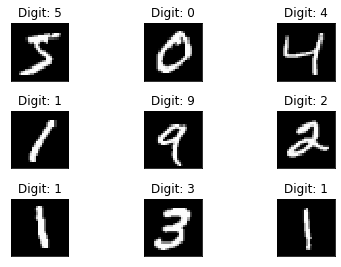

In [ ]:
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Input
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
ya=y_train.copy()

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

input_shape = ( 28, 28, 1)


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)/255.
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)/255.
y_train=y_train.astype(np.int64)
y_test=y_test.astype(np.int64)
dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(100).shuffle(1000, reshuffle_each_iteration=True)
X_test.shape

In [ ]:
class MyDence(tf.keras.layers.Layer):
  def __init__(self,num_outputs):
    super(MyDence,self).__init__()
    self.out=num_outputs

  def build(self,input_shape):
    self.kernel=self.add_weight(shape=[self.out,input_shape[-1]],initializer='glorot_normal', trainable=True,)
    # self.kernel=tf.Variable(tf.random.normal([self.out,input_shape[-1]]),i)

  def call(self,input):
    xw=tf.matmul(input,tf.transpose(self.kernel))
    w_norm = tf.norm(self.kernel, axis = 1) + 1e-8
    logits = xw/w_norm
    return logits
layer=MyDence(10) 

In [ ]:
num_category = 10


inp=Input(input_shape)
x=Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,)(inp)
x=Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape,)(inp)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,)(inp)
x=Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)


x=Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,)(x)
x=Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,)(x)
x=MaxPooling2D(pool_size=(2, 2))(x)

x=Flatten()(x)
x=Dense(128, activation='relu',)(x)
x1=Dense(2,use_bias=False,)(x)
x=layer(x1)

model=Model(inp,[x,x1])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)        

In [ ]:
from sklearn.metrics import accuracy_score

epochs = 30
eps = 1e-8
batch_size = 100
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer =tf.keras.optimizers.Adam(0.0001)
for epoch in range(epochs):
  for step, (x_batch_train, y) in enumerate(dataset):
    with tf.GradientTape() as tape:

            o = model(x_batch_train, training=True)
            logits=o[0]
            x=o[1]
    
            
            ordinal = tf.constant(list(range(0, y.get_shape()[0])), tf.int64)
            ordinal_y = tf.stack([ordinal, y], axis = 1)
            x_norm = tf.norm(x, axis = 1) + eps
            sel_logits = tf.gather_nd(logits, ordinal_y)
            cos_th = sel_logits/x_norm

            cos_th2 = tf.square(cos_th)
            cos_th4 = tf.pow(cos_th, 4)
            sign0 = tf.sign(cos_th)
            sign3 = tf.multiply(tf.sign(2*cos_th2 - 1), sign0)
            sign4 = 2*sign0 + sign3 - 3
            res = sign3*(8*cos_th4 - 8*cos_th2 + 1) + sign4
            scaled_logits = tf.multiply(res, x_norm)
            
            comb_logits_diff = tf.add(logits, tf.scatter_nd(ordinal_y, tf.subtract(scaled_logits, sel_logits), logits.get_shape()))
            
            loss_value =scce(y, comb_logits_diff)
            # print(logits,res)
            # print(loss_value)
           
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
          



  if epoch%1==0:
 
    logits = model(X_test, training=False)  

    
   
    # ordinal = tf.constant(list(range(0, 10000)), tf.int64)
    # ordinal_y = tf.stack([ordinal, y], axis = 1)
    # x_norm = tf.norm(X_test, axis = 1) + eps
    # sel_logits = tf.gather_nd(logits, ordinal_y)
    # cos_th = sel_logits/x_norm

    # cos_th2 = tf.square(cos_th)
    # cos_th4 = tf.pow(cos_th, 4)
    # sign0 = tf.sign(cos_th)
    # sign3 = tf.multiply(tf.sign(2*cos_th2 - 1), sign0)
    # sign4 = 2*sign0 + sign3 - 3
    # res = sign3*(8*cos_th4 - 8*cos_th2 + 1) + sign4
    # scaled_logits = tf.multiply(res, x_norm)
    
    # comb_logits_diff = tf.add(logits, tf.scatter_nd(ordinal_y, tf.subtract(scaled_logits, sel_logits), logits.get_shape()))
    soft=tf.nn.softmax(logits[0])
    loss_value =scce(y_test, logits[0]).numpy()
    out=tf.math.argmax(soft,axis=1)
    test=accuracy_score(y_test, out)
    print("test acc "+str(test)+" test loss "+str(loss_value))
  
            
            




    
  
  print("epoch : "+ str(epoch)+" loss : "+str(loss_value))
  print()

test acc 0.724 test loss 1.099696
epoch : 0 loss : 1.099696

test acc 0.8302 test loss 0.8367416
epoch : 1 loss : 0.8367416

test acc 0.8623 test loss 0.6936527
epoch : 2 loss : 0.6936527

test acc 0.9469 test loss 0.50220126
epoch : 3 loss : 0.50220126

test acc 0.9557 test loss 0.399468
epoch : 4 loss : 0.399468

test acc 0.9644 test loss 0.2999533
epoch : 5 loss : 0.2999533

test acc 0.9751 test loss 0.24229228
epoch : 6 loss : 0.24229228

test acc 0.9752 test loss 0.21400337
epoch : 7 loss : 0.21400337

test acc 0.9792 test loss 0.18958372
epoch : 8 loss : 0.18958372

test acc 0.9801 test loss 0.16400558
epoch : 9 loss : 0.16400558

test acc 0.9817 test loss 0.14779693
epoch : 10 loss : 0.14779693

test acc 0.9829 test loss 0.13549931
epoch : 11 loss : 0.13549931

test acc 0.9824 test loss 0.12547694
epoch : 12 loss : 0.12547694

test acc 0.9809 test loss 0.12304257
epoch : 13 loss : 0.12304257

test acc 0.9838 test loss 0.10841431
epoch : 14 loss : 0.10841431

test acc 0.9846 test

((60000, 10), (60000,))

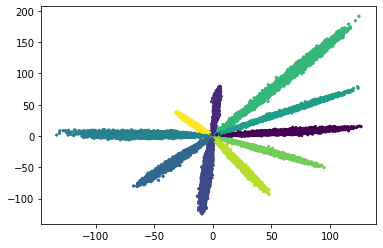

In [ ]:
model2=Model(model.input,model.layers[-1].output)
h=model2.predict(X_train[:])
plt.scatter(h[:,0],h[:,1],c=ya,s=5)
h.shape,ya.shape